In [2]:
import torch
import sys
sys.path.append("..")
from transformers import BertTokenizer
from model.gcn import CA_GCN
from data_loader.SportsDB_data_loader import SportsTablesDataset, get_LabelEncoder, SportsTablesDGLDataset, SportsTablesDGLDataset_df
from data_loader.GitTables_data_loader import GitTablesDGLDataset_enriched
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from time import time
import dgl
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from dgl.dataloading import GraphDataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(get_LabelEncoder().classes_)
max_length = 254
batch_size = 1
num_train_epochs = 30
bert_shortcut_name = "bert-base-uncased"
learning_rate = 5e-5
eps=1e-8
random_state = 1
sport_domains = ["football"]

tokenizer = BertTokenizer.from_pretrained(bert_shortcut_name)
model = CA_GCN(bert_shortcut_name=bert_shortcut_name, hidden_feats=512, num_classes=num_classes)

# train_dataset = SportsTablesDGLDataset_df(tokenizer=tokenizer, max_length=max_length, device=device, sport_domains=sport_domains, random_state=random_state)
# valid_dataset = SportsTablesDGLDataset_df(tokenizer=tokenizer, max_length=max_length, device=device, sport_domains=sport_domains, random_state=random_state, split="valid")
# test_dataset = SportsTablesDGLDataset_df(tokenizer=tokenizer, max_length=max_length, device=device, sport_domains=sport_domains, random_state=random_state, split="test") 
train_dataset = GitTablesDGLDataset_enriched(tokenizer=tokenizer, max_length=max_length, device=device, random_state=random_state, split="train", force_reload=False)
train_dataset.to_device()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Has Chache? => True
/ext/daten-wi/slangenecker/column_annotation_gnn/data_loader/tmp/GitTables_train_dataset_enriched_ml254_1_False.bin
Loading graphs from tmp file...


In [3]:
print(f"Train dataset size: {train_dataset.__len__()} (Tables)")

Train dataset size: 25743 (Tables)


In [39]:
dtypes = []

    dtypes.append(graph.nodes["num_feature_node"].data["data_tensor"].dtype)

set(dtypes)

{torch.float64}

In [23]:
from dgl.dataloading import GraphDataLoader

train_dataloader = GraphDataLoader(train_dataset, batch_size=4, drop_last=False)

In [25]:
# Training 
for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx == 0:
        print(batch)
    else:
        break

Graph(num_nodes={'column': 44, 'num_feature_node': 39, 'table': 4},
      num_edges={('column', 'column_column', 'column'): 104, ('num_feature_node', 'num_feature_column', 'column'): 39, ('table', 'table_column', 'column'): 44},
      metagraph=[('column', 'column', 'column_column'), ('num_feature_node', 'column', 'num_feature_column'), ('table', 'column', 'table_column')])


In [2]:
print(f"Train dataset size: {train_dataset.__len__()} (Tables)")
print(f"Valid dataset size: {valid_dataset.__len__()} (Tables)")
print(f"Test dataset size: {test_dataset.__len__()} (Tables)")

Train dataset size: 193 (Tables)
Valid dataset size: 49 (Tables)
Test dataset size: 61 (Tables)


In [3]:
print(f"Train dataset size: {sum([len(x) for x in train_dataset])} (Columns)")
print(f"Valid dataset size: {sum([len(x) for x in valid_dataset])} (Columns)")
print(f"Test dataset size: {sum([len(x) for x in test_dataset])} (Columns)")

Train dataset size: 4310 (Columns)
Valid dataset size: 1126 (Columns)
Test dataset size: 1328 (Columns)


In [4]:
train_types = [x["column_label"].tolist() for x in train_dataset]
train_types = [s_type for s_list in train_types for s_type in s_list]

valid_types = [x["column_label"].tolist() for x in valid_dataset]
valid_types = [s_type for s_list in valid_types for s_type in s_list]

test_types = [x["column_label"].tolist() for x in test_dataset]
test_types = [s_type for s_list in test_types for s_type in s_list]

train_types_counts = np.unique(train_types, return_counts=True)
valid_types_counts = np.unique(valid_types, return_counts=True)
test_types_counts = np.unique(test_types, return_counts=True)

df_train_types = pd.DataFrame({"semantic_type": train_types_counts[0], "train_counts":train_types_counts[1]})
df_valid_types = pd.DataFrame({"semantic_type": valid_types_counts[0], "valid_counts":valid_types_counts[1]})
df_test_types = pd.DataFrame({"semantic_type": test_types_counts[0], "test_counts":test_types_counts[1]})

df_types = df_train_types.set_index("semantic_type").join(df_valid_types.set_index("semantic_type")).join(df_test_types.set_index("semantic_type")).fillna(0).astype({"train_counts":"int64", "valid_counts":"int64", "test_counts":"int64"}).sort_values(by=["train_counts"])

In [5]:
df_types

,train_counts,valid_counts,test_counts
semantic_type,,,
football.coach.name,1,0,0
football.team.total_wins,1,0,0
football.team.total_ties,1,0,0
football.team.total_losses,1,0,0
football.team.super_bowl_wins,1,0,0
...,...,...,...
football.player.games_started,138,37,40
football.player.games_played,138,37,40
football.player.name,142,37,40


Text(0.5, 1.0, "Sport domain: ['football'] / random state: 4")

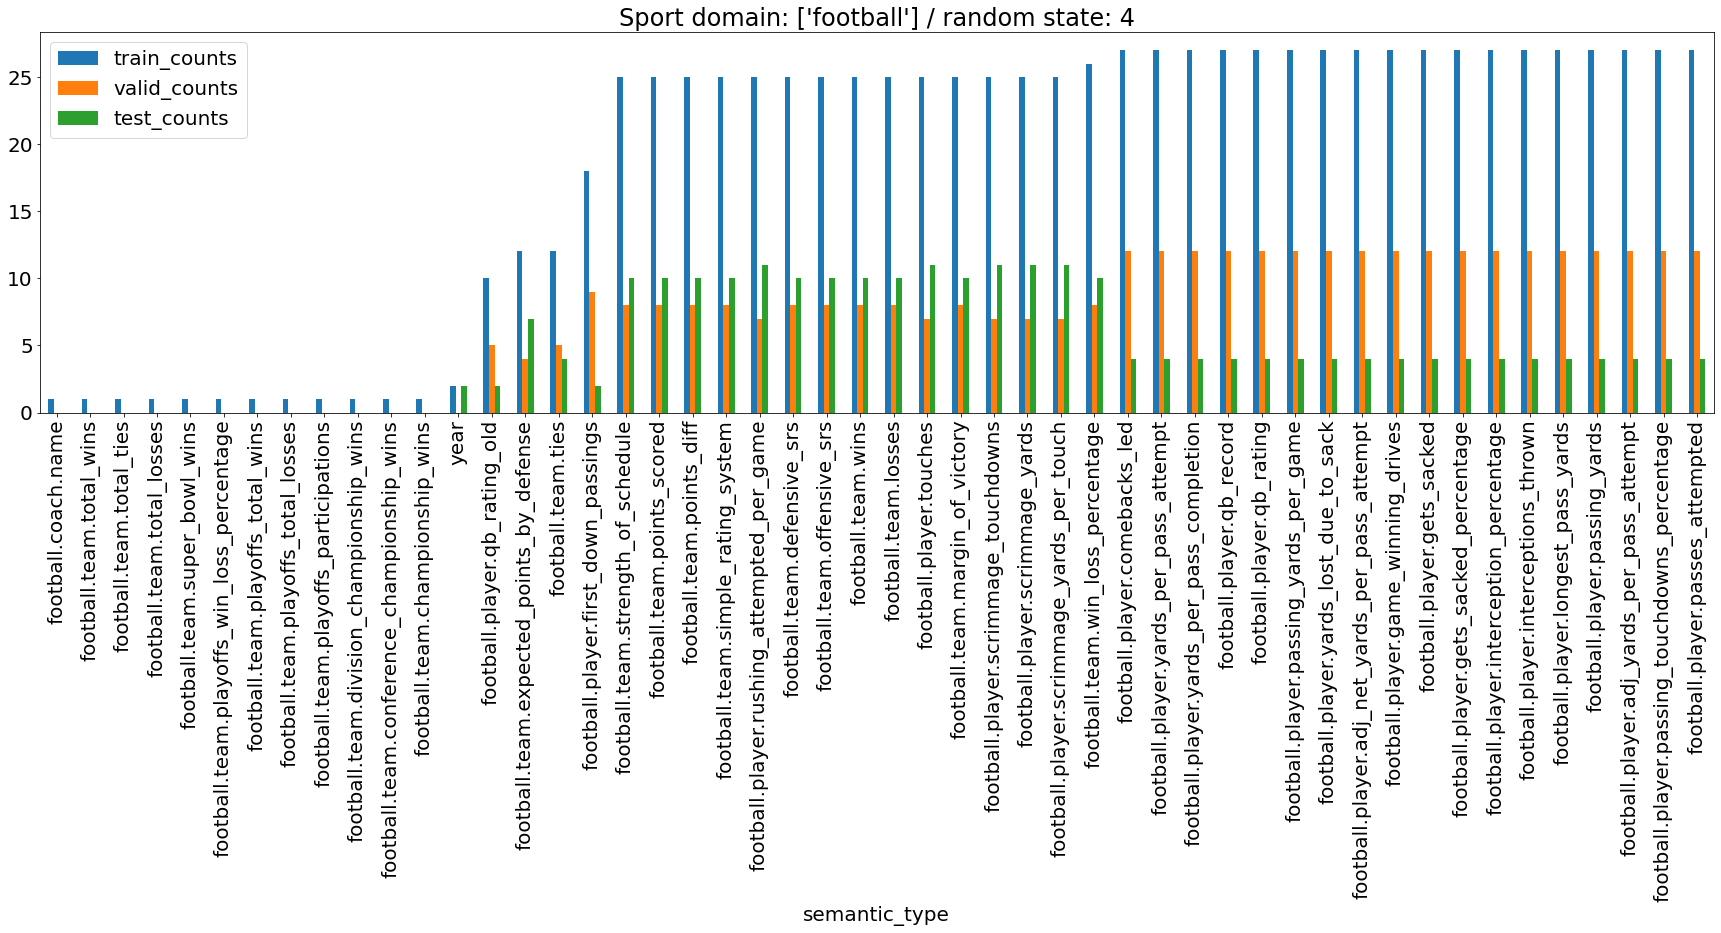

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})


ax = df_types[:50].plot.bar(figsize=(30,7))
ax.set_title(f"Sport domain: {sport_domains} / random state: {random_state}")

Text(0.5, 1.0, "Sport domain: ['football'] / random state: 4")

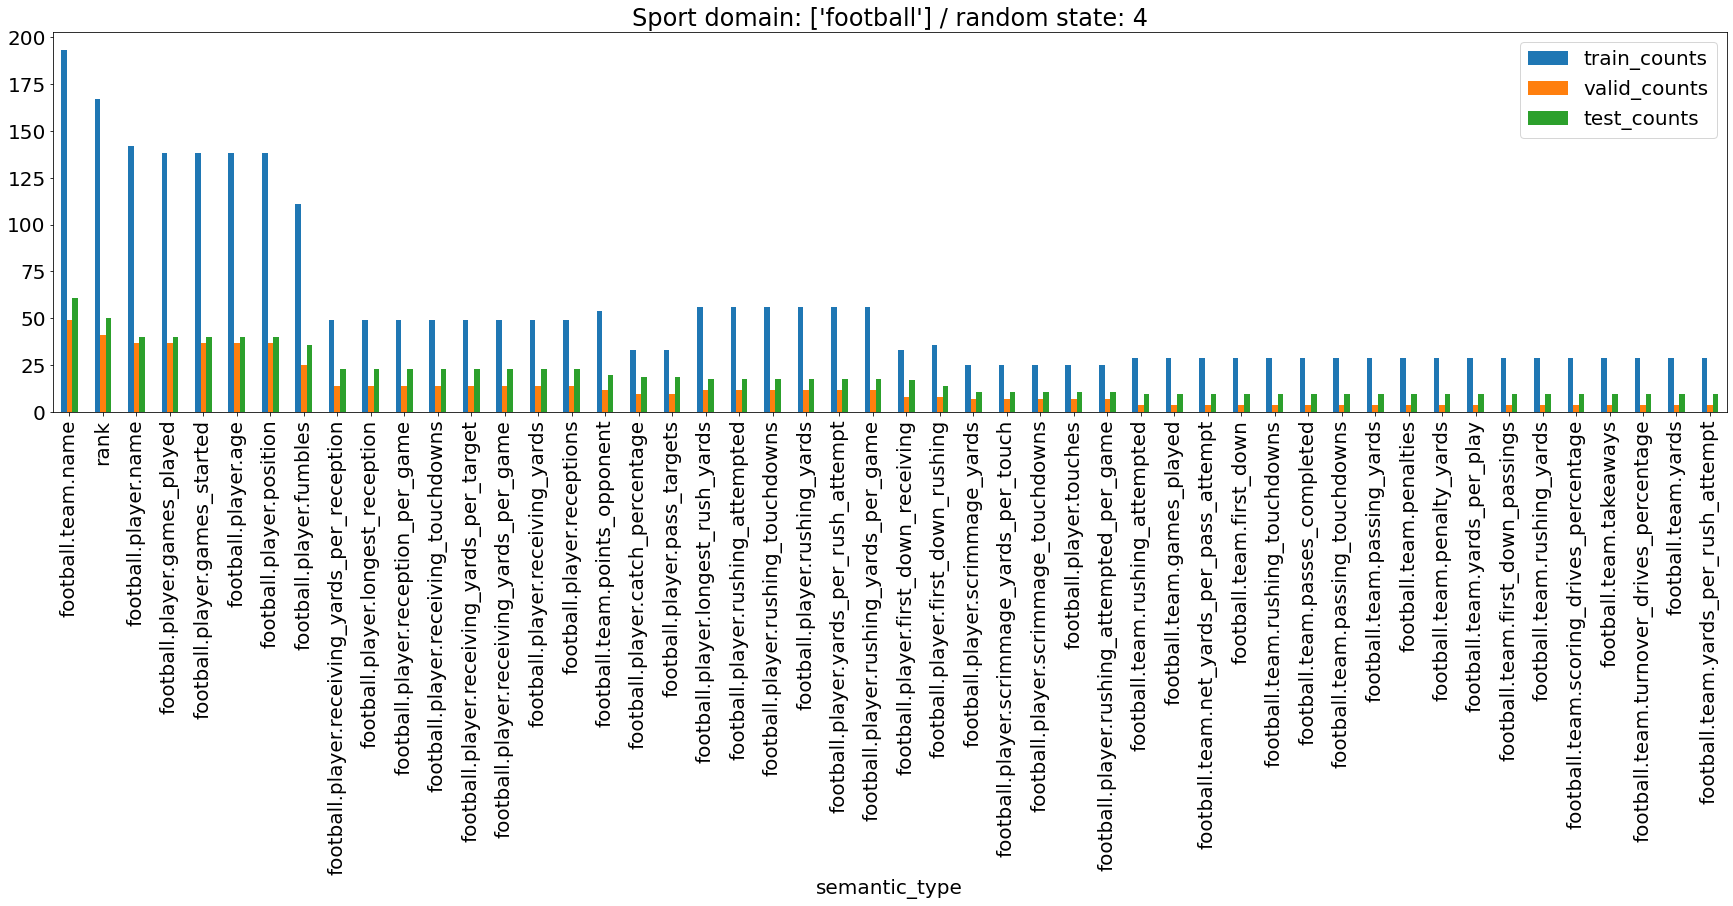

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})


ax = df_types.sort_values(by=["test_counts"], ascending=False)[:50].plot.bar(figsize=(30,7))
ax.set_title(f"Sport domain: {sport_domains} / random state: {random_state}")